# BestHack2022 DataScience

## Формулировка задания

По статистике каждый активный абонент в среднем получает более 5-ти нежелательных звонков в неделю. При этом
для разных людей понятия «желаемого» и «нежелательного» трафика могут не совпадать. Один и тот же номер
может использоваться как для назойливого рекламного обзвона, так и для обслуживания клиентов; а на каждого
нового мошенника реагировать нужно как можно быстрее.

В архиве [`transactions.zip`](https://drive.google.com/drive/folders/1Bn3bvV5u15a7enelJwmqyRrWu9Dfm-eZ)
содержатся синтетические данные транзакций голосового трафика за 2 месяца, максимально приближенные к
реальным. В файле `beeline_antispam_hakaton_id_samples.csv` содержатся __id__ абонентов, таргет по которым
известен (train) и по которым нужно предсказать (test).

Сможете ли вы определить, к какому типу относится конкретный номер?
Сможете ли вы построить стабильную и легкую модель?


## Часть I - ML

Требуется построить модель, которая классифицировала бы номера на 5 категорий:
- 0 - не спам
- 1 - небольшие полезные ИП / малые бизнесы
- 2 - организации
- 3 - мобильная карусель
- 4 - чёрные спамеры и мошенники

Метрика - [`fbeta_score(average='macro', beta=0.5)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html).

На выходе мы ожидаем файл `beeline_antispam_hakaton_id_samples.csv`, в котором для тестовых данных (test)
проставлена одна из 5 категорий.


## Часть II - R&D

Помимо точности предсказания, мы также будем оценивать <u>применимость решения в боевых условиях</u> и
<u>качество инсайтов</u>, полученных из данных.

Идеальное решение должно быть не только точным, но также __стабильным__ и __«лёгким»__.

Лёгким, так как реальные данные в тысячи раз тяжелее, а модель должна работать в режиме, приближенном к
real-time, чтобы с минимальной задержкой реагировать даже на самых продвинутых мошенников, которые быстро
меняют номера и подстраивают своё поведение для обхода антифрод-систем.

Под «лёгкостью» мы понимаем не столько сложность самого алгоритма (одна бустинг модель вполне ОК, десять
«застеканных» моделей - нет), сколько глубину используемых данных (необязательно использовать целый месяц,
можно попробовать ограничиться одной неделей или несколькими днями, если это не сильно влияет на точность).
    
Под стабильностью мы понимаем постоянство качества модели в динамике как в целом по категориям, так и по
каждому конкретному номеру (в идеальном мире один и тот же номер, если он не меняет фактического владельца,
должен иметь одинаковый скор и вчера, и сегодня и завтра). Метрику стабильности, в особенности для случая
с конкретными номерами, мы предлагаем вам придумать самим.

В частности, нам бы хотелось, чтобы вы ответили на следующие вопросы (но, возможно, вы захотите
поисследовать в данных что-то ещё):
1. Какие паттерны поведения номеров помогают отделить категории 1-4 друг от друга?
2. Насколько отличаются предсказания модели, построенные на разных периодах времени?
3. Не «ломается» ли модель в выходные и праздники?
4. Какое минимальное количество дней исторических транзакций требуется для, чтобы построить стабильную
и достаточно точную модель?
5. Какую метрику стабильности скора по отдельным номерам вы предлагаете использовать?
6. Как модель работает на слабоактивных номерах?
7. Среди номеров из наиболее «спорных» категорий 2 и 3, возможно ли выделить полезный и нежелательный
трафик на уровне конкретного звонка?

Мы очень приветствуем, чтобы ваши выводы были подкреплены конкретными цифрами и графиками (визуализация
должна подтверждать тезис и быть читаемой, но её красота сама по себе не оценивается).

Удачи!


### Описание данных
- `id _a` - id абонента, который звонит
- `id _b` - id абонента, которому звонят
- `time_key` - дата звонка
- `start_time_local` - время начала звонка
- `time_zone` - часовая зона звонящего абонента
- `duration` - длительность звонка
- `forward` - индикатор переадресации
- `zero_call_glg` - категория звонка с нулевой длительностью
- `source_b` - индикатор транзакции из источника B
- `source_f` - индикатор транзакции из источника F
- `num_b_length` - длина номера абонента, которому звонят


**Обработка данных**

In [26]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse

samples = pd.read_csv('beeline_antispam_hakaton_id_samples.csv')

data = pd.read_csv('./time_key=2021-11-01.csv')
print(data.head())

                      


       id_a        id_b start_time_local  time_zone  duration  forward  \
0  67596082  43588153.0         18:43:03        3.0       0.0      0.0   
1   4024969  67656553.0         11:43:20        4.0     206.0      0.0   
2  43166780  31861625.0         10:32:36        0.0       5.0      0.0   
3  51817902  41201237.0         13:45:02        3.0       0.0      0.0   
4  41812796   4932754.0         13:53:12        0.0       0.0      0.0   

   zero_call_flg  source_b  source_f  num_b_length    time_key  
0            3.0       0.0       1.0          10.0  2021-11-01  
1            5.0       1.0       0.0          10.0  2021-11-01  
2            0.0       0.0       1.0          10.0  2021-11-01  
3            0.0       0.0       1.0          10.0  2021-11-01  
4            5.0       0.0       1.0          10.0  2021-11-01  


Выделим фичи из датасета и поделим их на числовые и категориальные.

In [27]:
num_cols = [
    'start_time_local',
    'duration',
    'num_b_length',
    'time_key'
]

cat_cols = [
    'id_a',
    'id_b',
    'time_zone',
    'forward',
    'zero_call_flg',
    'source_b',
    'source_f',
]

cols = num_cols + cat_cols


Посмотрим на пропущенные значения и уберем их при необходимости

In [28]:

print(data.isna().mean())
data = data.dropna()

id_a                0.000000e+00
id_b                3.672010e-07
start_time_local    3.672010e-07
time_zone           3.672010e-07
duration            3.672010e-07
forward             3.672010e-07
zero_call_flg       3.672010e-07
source_b            3.672010e-07
source_f            3.672010e-07
num_b_length        3.672010e-07
time_key            3.672010e-07
dtype: float64


Распределение звонков по локальному времени:

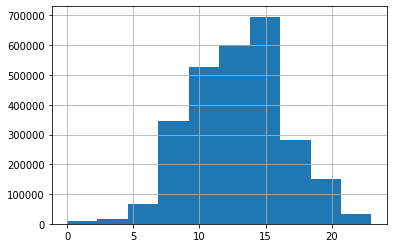

In [29]:
data = data[cols]
hours_distributions = data['start_time_local'].str.slice(0, 2).astype(int)
fig = hours_distributions.hist().get_figure()

Распределение звонков по UTC:

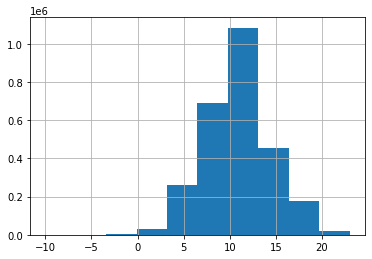

In [30]:
hours_distributions_UTS = hours_distributions - data['time_zone'].astype(int)
fig = hours_distributions_UTS.hist().get_figure()

**Посмотрим на распределение фичей**

In [31]:
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

id_a DISTRIBUTION
6325350     543609
1741727     370868
51817902    191219
52273536     93895
41812796     86395
             ...  
12401970         1
39415088         1
17168957         1
5654349          1
12957654         1
Name: id_a, Length: 15002, dtype: int64

id_b DISTRIBUTION
5137773.0     45269
67511626.0     4319
7055569.0      3618
70502169.0     3339
3969649.0      2263
              ...  
85529681.0        1
84721540.0        1
27574259.0        1
4219377.0         1
57977050.0        1
Name: id_b, Length: 1831386, dtype: int64

time_zone DISTRIBUTION
 3.0     1615085
 0.0      943827
 4.0       66528
 2.0       52037
 7.0       33181
 5.0        6219
 1.0        3202
 8.0        1103
-1.0         969
 10.0        632
 6.0         296
 11.0        130
 9.0          83
 12.0         11
Name: time_zone, dtype: int64

forward DISTRIBUTION
0.0    2472760
1.0     250543
Name: forward, dtype: int64

zero_call_flg DISTRIBUTION
0.0    1547719
5.0     958648
2.0      69928
1.0    

**Визуализируем распределение категориальных фичей**

Распределение часовых зон:


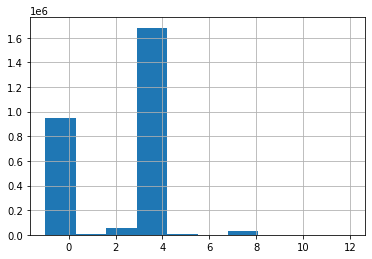

In [32]:

h = data['time_zone'].hist()
fig = h.get_figure()

Распределение категории звонка с нулевой длительностью:

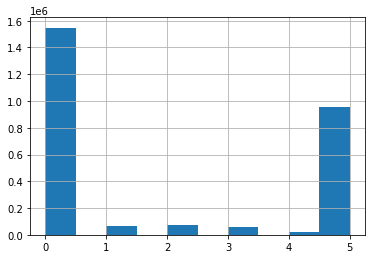

In [33]:
h = data['zero_call_flg'].hist()
fig = h.get_figure()

**Преобразуем время к числу**

In [34]:
time = pd.to_datetime(data['start_time_local'])
for i in range(len(time)):
  time[i] = time[i].time()
  time[i] = (time[i].hour * 60 + time[i].minute) * 60 + time[i].second

data['start_time_local'] = time
print(time.head())

0    67383
1    42200
2    37956
3    49502
4    49992
Name: start_time_local, dtype: object


**Преобразуем дату к числу**

In [ ]:
date = pd.to_datetime(data['time_key'])
for i in range(len(date)):
  date[i] = date[i].date()
  # TODO: consider leap years and quantity of days in certain month
  date[i] = date[i].year * 365 + date[i].month * 30 + date[i].day